<a href="https://colab.research.google.com/github/PabloContrerasA/OASIS-3-Dementia-Severity-Determining-Neural-Network-FNN-/blob/main/Felipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [682]:
# Imports

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
os.environ['TF_DETERMINISTIC_OPS'] = '1'
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers

In [683]:
# Setting a seed for reproducible results

seed = 10

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [684]:
# Download OASIS Datasets

neuro_exam_data = pd.read_csv("OASIS3_UDSb8_neuro_exam.csv")
health_history_data = pd.read_csv("OASIS3_UDSa5_health_history.csv")
demographic_data =  pd.read_csv("OASIS3_demographics.csv")
cdr_data = pd.read_csv("OASIS3_UDSb4_cdr.csv")

In [685]:
# Take only necessary columns from each dataset

#- - - demographic

demographic_data['hand_binary'] = demographic_data['HAND'].map({'L': 1, 'R': 0})
demographic_data = demographic_data.drop(columns=["race", "ETHNIC", "AIAN", "NHPI","ASIAN", "AA", "WHITE","HAND", "AgeatDeath"])

# - - - neuro exam

neuro_exam_data = neuro_exam_data[["OASISID","days_to_visit", "NORMAL", "FOCLDEF", "GAITDIS","NORMEXAM"]]



# - - - cdr

cdr_data = cdr_data[["OASISID","days_to_visit", "MMSE", "memory", "orient", "judgment", "commun", "homehobb", "perscare", "CDRTOT"]]



#- - - health history

cols_to_keep = health_history_data.columns[:31]

#
health_history_data = health_history_data[cols_to_keep]
health_history_data = health_history_data.drop(columns=["PD","PDOTHR"])


In [686]:
health_history_data.head()

,OASISID,OASIS_session_label,days_to_visit,age at visit,CVHATT,CVAFIB,CVANGIO,CVBYPASS,CVPACE,CVCHF,...,HYPERTEN,HYPERCHO,DIABETES,B12DEF,THYROID,INCONTU,INCONTF,DEP2YRS,DEPOTHR,ALCOHOL
0,OAS30001,OAS30001_UDSa5_d0000,0,65.19,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,OAS30001,OAS30001_UDSa5_d0339,339,66.12,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,OAS30001,OAS30001_UDSa5_d0722,722,67.17,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
3,OAS30001,OAS30001_UDSa5_d1106,1106,68.22,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
4,OAS30001,OAS30001_UDSa5_d1456,1456,69.18,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [687]:
def fill_missing_data(df) :
  id = df["OASISID"]
  df = df.groupby("OASISID").ffill()
  df["OASISID"] = id
  return df

In [688]:
neuro_exam_data = fill_missing_data(neuro_exam_data)
cdr_data = fill_missing_data(cdr_data)
health_history_data = fill_missing_data(health_history_data)

In [689]:
# Some subjects were examined multiple times. Only take their most recent examination.
neuro_exam_data = neuro_exam_data.drop_duplicates(subset="OASISID", keep="last")
health_history_data = health_history_data.drop_duplicates(subset="OASISID", keep="last")
cdr_data= cdr_data.drop_duplicates(subset="OASISID", keep="last")

# Remove duplicate data
cols_to_drop = [
    "age at visit",
    "OASIS_session_label"
]

neuro_exam_data = neuro_exam_data.drop(columns=cols_to_drop, errors="ignore")
health_history_data = health_history_data.drop(columns=cols_to_drop, errors="ignore")
cdr_data = cdr_data.drop(columns=cols_to_drop, errors="ignore")

# Replacing NORMEXAM (0 = normal neuro results, 1 = abnormal results that correlate to symptoms described later, 2 = abnormal results that do not correlate to symptoms described later) with ABNORM (0 = normal results, 1 = abnormal results)

neuro_exam_data['ABNORM'] = (neuro_exam_data['NORMEXAM'] > 0).astype(int)
neuro_exam_data = neuro_exam_data.drop(columns = ["NORMEXAM"])

In [690]:
# Create clinical_data by merging all previous datasets
clinical_data = (
    neuro_exam_data
        .merge(health_history_data, on=["OASISID", "days_to_visit"], how="inner")
        .merge(cdr_data, on=["OASISID", "days_to_visit"], how="inner")
        .merge(demographic_data, on="OASISID", how="inner")
)

clinical_data = clinical_data.dropna(axis=1, how="all")

In [691]:
# Analyzing clinical_data
print(clinical_data.shape)
print(clinical_data.info())
print(clinical_data.isna().sum())
clinical_data.head()

(1335, 48)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1335 entries, 0 to 1334
Data columns (total 48 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   days_to_visit  1335 non-null   int64  
 1   NORMAL         975 non-null    float64
 2   FOCLDEF        975 non-null    float64
 3   GAITDIS        975 non-null    float64
 4   OASISID        1335 non-null   object 
 5   ABNORM         1335 non-null   int64  
 6   CVHATT         1330 non-null   float64
 7   CVAFIB         1330 non-null   float64
 8   CVANGIO        1329 non-null   float64
 9   CVBYPASS       1330 non-null   float64
 10  CVPACE         983 non-null    float64
 11  CVCHF          1330 non-null   float64
 12  CVOTHR         1330 non-null   float64
 13  CBSTROKE       1330 non-null   float64
 14  CBTIA          1330 non-null   float64
 15  CBOTHR         983 non-null    float64
 16  SEIZURES       1330 non-null   float64
 17  TRAUMBRF       983 non-null    float64
 1

,days_to_visit,NORMAL,FOCLDEF,GAITDIS,OASISID,ABNORM,CVHATT,CVAFIB,CVANGIO,CVBYPASS,...,CDRTOT,AgeatEntry,GENDER,EDUC,SES,racecode,daddem,momdem,APOE,hand_binary
0,5184,1.0,0.0,0.0,OAS30001,1,0.0,0.0,0.0,0.0,...,0.0,65.1945,2,12.0,4.0,5,5.0,1.0,23.0,0.0
1,2961,1.0,0.0,0.0,OAS30002,0,0.0,0.0,0.0,0.0,...,0.0,67.2521,1,18.0,2.0,5,0.0,1.0,34.0,0.0
2,5651,1.0,0.0,0.0,OAS30003,1,0.0,0.0,0.0,0.0,...,0.0,58.8137,2,18.0,1.0,5,0.0,0.0,33.0,0.0
3,5512,1.0,0.0,0.0,OAS30004,0,0.0,0.0,0.0,0.0,...,0.0,55.1342,2,17.0,1.0,5,1.0,1.0,23.0,1.0
4,4417,1.0,0.0,0.0,OAS30005,0,0.0,0.0,0.0,0.0,...,0.0,48.0630,2,16.0,3.0,2,0.0,0.0,33.0,0.0


A considerable number of subjects do not have data for variables important variables

In [692]:
clinical_data = clinical_data.dropna()
print(clinical_data.shape)
print(clinical_data.info())
print(clinical_data.isna().sum())
clinical_data.head()

(908, 48)
<class 'pandas.core.frame.DataFrame'>
Index: 908 entries, 0 to 1253
Data columns (total 48 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   days_to_visit  908 non-null    int64  
 1   NORMAL         908 non-null    float64
 2   FOCLDEF        908 non-null    float64
 3   GAITDIS        908 non-null    float64
 4   OASISID        908 non-null    object 
 5   ABNORM         908 non-null    int64  
 6   CVHATT         908 non-null    float64
 7   CVAFIB         908 non-null    float64
 8   CVANGIO        908 non-null    float64
 9   CVBYPASS       908 non-null    float64
 10  CVPACE         908 non-null    float64
 11  CVCHF          908 non-null    float64
 12  CVOTHR         908 non-null    float64
 13  CBSTROKE       908 non-null    float64
 14  CBTIA          908 non-null    float64
 15  CBOTHR         908 non-null    float64
 16  SEIZURES       908 non-null    float64
 17  TRAUMBRF       908 non-null    float64
 18  TRAU

,days_to_visit,NORMAL,FOCLDEF,GAITDIS,OASISID,ABNORM,CVHATT,CVAFIB,CVANGIO,CVBYPASS,...,CDRTOT,AgeatEntry,GENDER,EDUC,SES,racecode,daddem,momdem,APOE,hand_binary
0,5184,1.0,0.0,0.0,OAS30001,1,0.0,0.0,0.0,0.0,...,0.0,65.1945,2,12.0,4.0,5,5.0,1.0,23.0,0.0
1,2961,1.0,0.0,0.0,OAS30002,0,0.0,0.0,0.0,0.0,...,0.0,67.2521,1,18.0,2.0,5,0.0,1.0,34.0,0.0
2,5651,1.0,0.0,0.0,OAS30003,1,0.0,0.0,0.0,0.0,...,0.0,58.8137,2,18.0,1.0,5,0.0,0.0,33.0,0.0
3,5512,1.0,0.0,0.0,OAS30004,0,0.0,0.0,0.0,0.0,...,0.0,55.1342,2,17.0,1.0,5,1.0,1.0,23.0,1.0
4,4417,1.0,0.0,0.0,OAS30005,0,0.0,0.0,0.0,0.0,...,0.0,48.0630,2,16.0,3.0,2,0.0,0.0,33.0,0.0


In [693]:
print(clinical_data["CDRTOT"].value_counts())

CDRTOT
0.0    549
0.5    140
2.0    107
1.0     98
3.0     14
Name: count, dtype: int64


In [694]:
# Separate input data that will be used to make the prediction and the target CDR data which is the real diagnosis. Changes categorical data to numeric data. Also removed redundant categories.

x = clinical_data.drop(columns=['OASISID','CDRTOT'])
y = clinical_data["CDRTOT"]

# Separates data into training and testing data

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2, random_state=seed, stratify = y)

In [695]:
unique_cdr = clinical_data['CDRTOT'].unique()
print(unique_cdr)

[0.  1.  0.5 2.  3. ]


In [696]:
# Creating classes for sparse-categorical-crossentropy

value_to_class = {0: 0, 0.5: 1, 1: 2, 2: 3, 3: 4}
y_train_classes = np.array([value_to_class[y] for y in y_train])
y_test_classes = np.array([value_to_class[y] for y in y_test])

In [697]:
# Normalizing data by scaling

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [698]:
# Assigns Class Weights

unique, counts = np.unique(y_train_classes, return_counts=True)
class_weight = {i: max(counts)/c for i,c in zip(unique, counts)}

In [699]:
# Neural Network

model = tf.keras.Sequential([
tf.keras.Input(shape=(x_train.shape[1],)),
tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
 tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(5, activation='softmax')
])

model.compile( optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', ] )


In [700]:
# Early stopping to prevent overfitting

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 5, restore_best_weights=True
)

In [701]:
# Trains

history = model.fit(
    x_train, y_train_classes,
    epochs = 200,
    shuffle = True,
    batch_size=32,
    validation_split = 0.2,
    class_weight=class_weight,
    callbacks=[early_stop]
)

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1727 - loss: 16.1575 - val_accuracy: 0.2192 - val_loss: 10.4718
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2942 - loss: 13.7854 - val_accuracy: 0.4589 - val_loss: 9.5349
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4665 - loss: 12.9303 - val_accuracy: 0.6233 - val_loss: 8.7576
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5656 - loss: 11.8100 - val_accuracy: 0.6781 - val_loss: 8.0720
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6714 - loss: 10.2528 - val_accuracy: 0.6781 - val_loss: 7.4740
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6639 - loss: 9.8062 - val_accuracy: 0.7055 - val_loss: 6.9174
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7421 - loss: 8.9675 - val_accuracy: 0.7192 - val_loss: 6.4366
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7439 - loss: 8.8414 - val_accuracy: 0.7

In [702]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test).argmax(axis=1)
print(classification_report(y_test_classes, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       110
           1       0.94      0.57      0.71        28
           2       0.86      0.90      0.88        20
           3       0.85      0.81      0.83        21
           4       0.40      0.67      0.50         3

    accuracy                           0.89       182
   macro avg       0.79      0.79      0.77       182
weighted avg       0.90      0.89      0.89       182



In [703]:
model.evaluate(x_test,y_test_classes)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9188 - loss: 0.8696 


[0.9024165272712708, 0.8901098966598511]

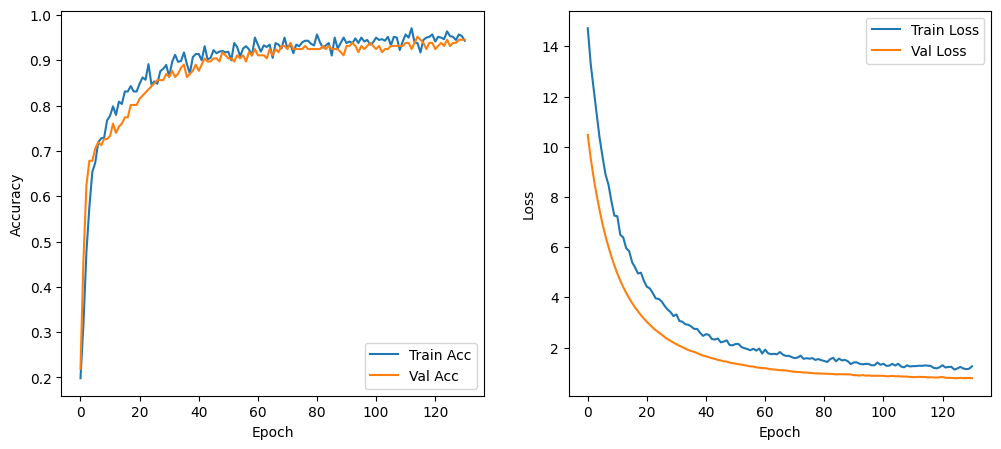

In [704]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

a (initial scale): 9.4935
b (decay rate): 0.0720
c (asymptotic loss): 0.9518


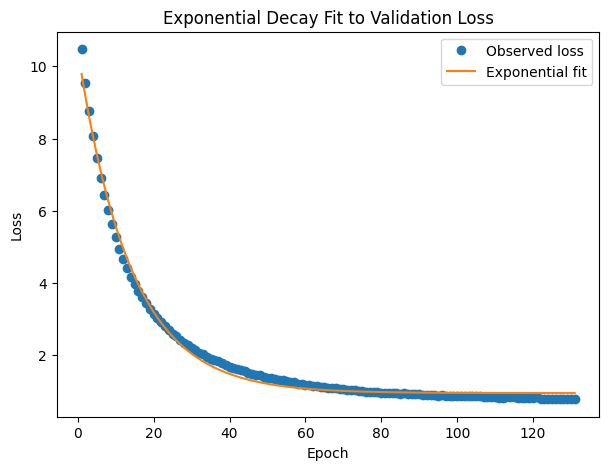

In [705]:
loss = np.array(history.history['val_loss'])

epochs = np.arange(1, len(loss) + 1)


def exp_decay(t, a, b, c):
    return a * np.exp(-b * t) + c


initial_guess = [loss[0], 0.1, loss[-1]]


params, covariance = curve_fit(
    exp_decay,
    epochs,
    loss,
    p0=initial_guess,
    maxfev=10000
)

a, b, c = params

print(f"a (initial scale): {a:.4f}")
print(f"b (decay rate): {b:.4f}")
print(f"c (asymptotic loss): {c:.4f}")

fitted_loss = exp_decay(epochs, a, b, c)

plt.figure(figsize=(7,5))
plt.plot(epochs, loss, 'o', label='Observed loss')
plt.plot(epochs, fitted_loss, '-', label='Exponential fit')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Exponential Decay Fit to Validation Loss')
plt.show()

In [706]:
ss_res = np.sum((loss - fitted_loss) ** 2)
ss_tot = np.sum((loss - np.mean(loss)) ** 2)

r_squared = 1 - (ss_res / ss_tot)

print(f"R^2 of exponential fit: {r_squared:.4f}")

R^2 of exponential fit: 0.9932
